### Implementation of machine learning models

In [3]:
train   = pd.read_csv("C:/Users/xzong/Desktop/MBD/Machine Learning/SML_Section7_v2.1/data/com1_default/default.csv", sep=";",low_memory=False)

In [2]:
import pandas as pd
import numpy as np
import os
import time

In [4]:
train = train.drop("Unnamed: 0",axis = 1)

In [5]:
train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
from sklearn.model_selection import train_test_split

X = train[train.columns[~train.columns.isin(['Y'])]]
y = train[['Y']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify = y)

logistic 	 AUC: 0.7177251620020153 
Accuracy: 0.8111111111111111 
Precision: 0.7181409295352323 
 
F1: 0.36042136945071485 
 {'C': 1, 'class_weight': None, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
          pred:yes  pred:no
true:yes      6821      188
true:no       1512      479 

randomForest 	 AUC: 0.7671597018943642 
Accuracy: 0.7724444444444445 
Precision: 0.48829568788501027 
 
F1: 0.5372797107998192 
 {'class_weight': 'balanced', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 250}
          pred:yes  pred:no
true:yes      5763     1246
true:no        802     1189 

knn 	 AUC: 0.6483685788502248 
Accuracy: 0.774 
Precision: 0.46112115732368897 
 
F1: 0.20047169811320759 
 {'leaf_size': 2, 'n_neighbors': 15, 'weights': 'distance'}
          pred:yes  pred:no
true:yes      6711      298
true:no       1736      255 

lda_svd 	 AUC: 0.7131906319198271 
Accuracy: 0.8113333333333334 
Precision: 0.7004103967168263 
 
F1: 0.3761939750183689 
 {'solver': 'svd'}
  

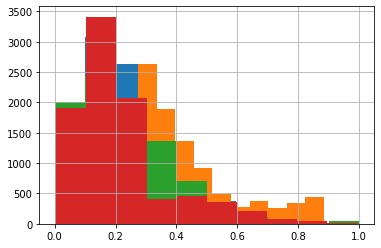

In [12]:
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, f1_score
from sklearn.svm                   import SVC 
import warnings
warnings.filterwarnings('ignore')

svm          = SVC()
logistic     = LogisticRegression()
randomForest = RandomForestClassifier()
knn          = KNeighborsClassifier()
lda          = LinearDiscriminantAnalysis()

models = {
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "knn"          :knn,
          #"svm"      : svm,
          "lda_svd"      : lda
         }

#Grid Values to loop through
grid_values = {
    "logistic":{"solver":["lbfgs", "newton-cg", "sag", "saga"],'penalty': ['l2'],'C':[0.1, 1, 5, 10, 0.01], 
                "max_iter":[100, 200], "class_weight":[None, "balanced"]},
    "randomForest":{"max_depth":[3,4], "n_estimators":[600, 250], "class_weight":["balanced"], 
                    "max_features":["auto","sqrt", "log2"]},
    "knn":{"n_neighbors":[15,3,5,7,9,10,12], "weights":["distance"], "leaf_size":[2,3]},
    "svm" : {'C': [1], 'gamma': [0.1],'kernel': ['rbf']},
    "lda_svd":{"solver":["svd"]}
}

overview = pd.DataFrame()
ing_pred = pd.DataFrame()

for model in models:

    grid_clf_acc = GridSearchCV(models[model], cv=3, param_grid = grid_values[model], scoring = 'average_precision')
    grid_clf_acc.fit(X_train, y_train)

    y_pred = grid_clf_acc.predict(X_valid)
    
    probabilities = pd.DataFrame(grid_clf_acc.predict_proba(X_valid))[1]
    auc           = roc_auc_score(np.array(y_valid),np.array(probabilities))
    acc           = accuracy_score(y_valid,y_pred)
    precision     = precision_score(y_valid,y_pred)
    f1            = f1_score(y_valid,y_pred)
    
    print(model, "\t", "AUC:", auc, "\nAccuracy:", acc, "\nPrecision:", precision,"\n" ,"\nF1:", f1,"\n",grid_clf_acc.best_params_)

    overview[model] = [auc, acc, grid_clf_acc.best_params_]
    
    cmtx = pd.DataFrame(
    confusion_matrix(y_valid, y_pred), 
    index=['true:yes', 'true:no'], 
    columns=['pred:yes', 'pred:no'])

    print(cmtx, "\n")
    probabilities.hist()

overview.index = ["AUC", "Accuracy", "best params"]